# Part 2

## Setup

In [1]:
using Plots
using JuMP, HiGHS

include("src/utils.jl")
include("src/lshaped.jl")

multicut_lshaped (generic function with 1 method)

In [2]:
DATA_DIR = "data/"

"data/"

In [3]:
prices = vec(read_file(DATA_DIR * "belpex_price.txt"))
states = vec(read_file(DATA_DIR * "markov_support_4.txt"))
P_prob = read_file(DATA_DIR * "markov_weights_4.txt")

4×4 Matrix{Float64}:
 0.394106    0.524075   0.0807228  0.00109546
 0.107876    0.564185   0.311323   0.016616
 0.016616    0.311323   0.564185   0.107876
 0.00109546  0.0807228  0.524075   0.394106

## Questions

Before considering the full multistage stochastic programming problem, let us trans-
form the problem into multistage problem that can be equivalently formulated as a
two-stage stochastic programming problem. In doing so, assume that the price in
the first 𝐹 hours of the day is perfectly known and equal to the expected price. Then,
generate 𝐾 scenarios that describe the evolution of the price for the next 𝑇 − 𝐹 hours.
Take 𝐹 = 5 and 𝐾 = 10. The scenario tree for this formulation is shown in Figure 2.

In [4]:
F = 5
K = 10

10

In [5]:
# prices_scenarios_idx = [sample_chain_indices(24 - F + 1, P_prob, states; initial_state = 1)[2:end] for i in 1:K]
# prices_scenarios = [prices[prices_scenarios_idx[i]] .* exp.(states[prices_scenarios_idx[i]]) for i in 1:K]


prices_scenarios = [prices[F+1:end] .* exp.(sample_chain(24 - F, P_prob, states)) for i in 1:K]
prices_prob = 1/K * ones(K)

# prices_prob = [P_prob[1, idx[1]] for idx in prices_scenarios_idx]
# prices_prob = prices_prob ./ sum(prices_prob)

10-element Vector{Float64}:
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1

### 1. Formulate the two-stage-equivalent multistage stochastic programming problem

Let us define stage one variables:
* $b_1 = (b_{1,1}, \dots, b_{1,F})$ where $b_{1t} =$ battery level at $t \leq F$
* $\eta_1 = (\eta_{1,1}, \dots, \eta_{1,F})$ (discharging)
* $\xi_1 = (\xi_{1,1}, \dots, \xi_{1,F})$ (charging)
* $P_1 = (P_{1,1}, \dots, P_{1,F})$ (price)

and the stage 2 variables :
* $b_{2,\omega} = (b_{1,F+1}(\omega), \dots, b_{1,T}(\omega))$ where $b_{1t} =$ battery level at $t > F$
* $\eta_{2,\omega} = (\eta_{1,F+1}(\omega), \dots, \eta_{1,T}(\omega))$ (discharging)
* $\xi_{2, \omega} = (\xi_{1,F+1}(\omega), \dots, \xi_{1,T}(\omega))$ (charging)
* $P_{2, \omega} = (P_{2,F+1}(\omega), \dots, P_{2,T}(\omega))$ (price)

Finally the problem reads:
$$
\begin{align*}
    \max& P_1 \cdot (0.9 \eta_1 - \frac{1}{0.9}\xi_1) + \mathbb{E}\bigg[P_{2, \omega}\cdot (0.9\eta_{2, \omega} - \frac{1}{0.9}\xi_{2,\omega})\bigg] \\
    \text{s.t.}~& A_1 b_1 + B_1 \eta_1 + C_1 \xi_1 = 0\\
    & A_1 b_{2, \omega} + B_1 \eta_{2, \omega} + C_1 \xi_{2, \omega} = 0,\quad \forall \omega \in \Omega\\
    &b_{2, F+1, \omega} = b_{1, F} - \eta_{2, F+1, \omega} + \xi_{2, F+1, \omega} \\
    &0\leq \eta_1 \leq 200, \quad 0\leq \eta_{2, \omega} \leq 200 \quad \forall \omega \in \Omega \\
    &0\leq \xi_1 \leq 200, \quad 0\leq \xi_{2, \omega} \leq 200 \quad \forall \omega \in \Omega \\
    & 0 \leq b_1 \leq 800, \quad 0 \leq b_{2, \omega} \leq 800,\quad \forall \omega \in \Omega \\
    & x_1, x_2, \eta_1, \eta_2, \xi_1, \xi_2 \geq 0

\end{align*}
$$

where $A_1, B_1, C_1$ are chosen accordingly.

### 2. Explain why this problem is equivalent to a two-stage stochastic program.


Given the scenario tree we can conclude that each branch is independent of the others meaning that although it involves mutiple stage, we can resume these into a single vector. Encapsulating the $F$ first desicion into a single vector, makes the problem a two-stage problem. 

### 3. Implement the L-Shaped and the multicut L-Shaped algorithm for solving this problem. For both algorithms, plot the evolution of the lower and upper bounds.

In [6]:
ret = lshaped(
    prices[1:F],
    prices_scenarios,
    prices_prob,
    1e6,
)

Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic lic

┌ Info: Adding Benders cut: -48.98696664935175 b1[6] - θ ≥ -40987.13846147068
└ @ Main /Users/theohanon/Desktop/Operational-Research/src/lshaped.jl:124


(lb = Any[58512.76068369295, 58512.7606836929], ub = Any[1.0175256222222223e6, 58512.7606836929], b1 = [0.0, 200.0, 400.0, 400.0, 200.0, 0.0], η1 = [0.0, 0.0, 0.0, 200.0, 200.0], ξ1 = [200.0, 200.0, 0.0, 0.0, 0.0], b2 = [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 200.0, 400.0, 600.0, 800.0, 800.0, 800.0, 600.0, 400.0, 200.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 200.0, 400.0, 600.0, 800.0, 800.0, 600.0, 600.0, 600.0, 400.0, 200.0, 200.0, 0.0], [0.0, 0.0, 0.0, 200.0, 0.0, 0.0, 0.0, 0.0, 200.0, 400.0, 600.0, 800.0, 800.0, 800.0, 800.0, 600.0, 400.0, 200.0, 200.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 200.0, 400.0, 600.0, 800.0, 800.0, 800.0, 800.0, 800.0, 600.0, 400.0, 200.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 200.0, 400.0, 600.0, 800.0, 800.0, 800.0, 600.0, 600.0, 400.0, 200.0, 200.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 200.0, 400.0, 600.0, 800.0, 800.0, 800.0, 800.0, 800.0, 600.0, 400.0, 200.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

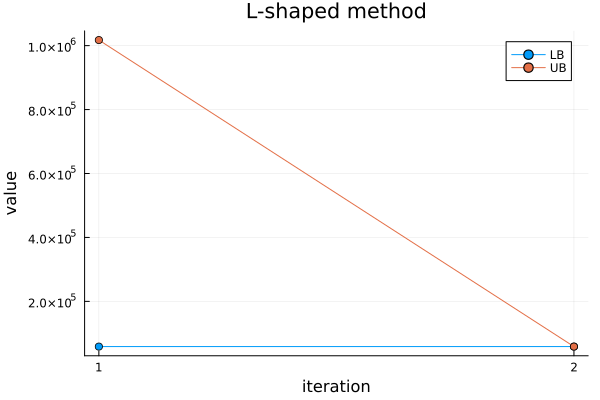

In [7]:
plot(
    ret.lb,
    label = "LB",
    title = "L-shaped method",
    xlabel = "iteration",
    ylabel = "value",
    legend = :topright,
    xticks = 1:2,
    marker= :circle,
)
plot!(
    ret.ub,
    label = "UB",
    legend = :topright,
    marker= :circle,
)

In [8]:
ret = multicut_lshaped(
    prices[1:F],
    prices_scenarios,
    prices_prob,
    1e5
)

Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic lic

┌ Info: Adding Benders cut: 40.45564058698213 b1[6] + θ[1] ≤ 34867.32417776501
└ @ Main /Users/theohanon/Desktop/Operational-Research/src/lshaped.jl:188
┌ Info: Adding Benders cut: 47.43930588221436 b1[6] + θ[2] ≤ 44041.4760729271
└ @ Main /Users/theohanon/Desktop/Operational-Research/src/lshaped.jl:188
┌ Info: Adding Benders cut: 49.82286599783771 b1[6] + θ[3] ≤ 42939.51720295503
└ @ Main /Users/theohanon/Desktop/Operational-Research/src/lshaped.jl:188
┌ Info: Adding Benders cut: 49.82286599783771 b1[6] + θ[4] ≤ 37408.16194958257
└ @ Main /Users/theohanon/Desktop/Operational-Research/src/lshaped.jl:188
┌ Info: Adding Benders cut: 55.028095383214925 b1[6] + θ[5] ≤ 43406.984049402956
└ @ Main /Users/theohanon/Desktop/Operational-Research/src/lshaped.jl:188
┌ Info: Adding Benders cut: 40.45564058698213 b1[6] + θ[6] ≤ 44687.0567172469
└ @ Main /Users/theohanon/Desktop/Operational-Research/src/lshaped.jl:188
┌ Info: Adding Benders cut: 47.43930588221436 b1[6] + θ[7] ≤ 40063.525633783705
└ 

(lb = Any[58512.760683692904, 58512.7606836929], ub = Any[117525.62222222223, 58512.7606836929], b1 = [0.0, 200.0, 400.0, 400.0, 200.0, 0.0], η1 = [0.0, 0.0, 0.0, 200.0, 200.0], ξ1 = [200.0, 200.0, 0.0, 0.0, 0.0], b2 = [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 200.0, 400.0, 600.0, 800.0, 800.0, 800.0, 600.0, 400.0, 200.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 200.0, 400.0, 600.0, 800.0, 800.0, 600.0, 600.0, 600.0, 400.0, 200.0, 200.0, 0.0], [0.0, 0.0, 0.0, 200.0, 0.0, 0.0, 0.0, 0.0, 200.0, 400.0, 600.0, 800.0, 800.0, 800.0, 800.0, 600.0, 400.0, 200.0, 200.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 200.0, 400.0, 600.0, 800.0, 800.0, 800.0, 800.0, 800.0, 600.0, 400.0, 200.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 200.0, 400.0, 600.0, 800.0, 800.0, 800.0, 600.0, 600.0, 400.0, 200.0, 200.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 200.0, 400.0, 600.0, 800.0, 800.0, 800.0, 800.0, 800.0, 600.0, 400.0, 200.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

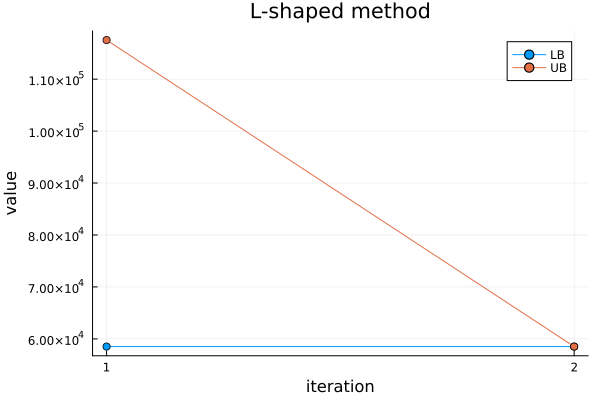

In [9]:
plot(
    ret.lb,
    label = "LB",
    title = "L-shaped method",
    xlabel = "iteration",
    ylabel = "value",
    legend = :topright,
    xticks = 1:2,
    marker= :circle,
)
plot!(
    ret.ub,
    label = "UB",
    legend = :topright,
    marker= :circle,
)

In [10]:
b1 = ret.b1
b2_w = ret.b2

10-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 200.0, 400.0, 600.0, 800.0, 800.0, 800.0, 600.0, 400.0, 200.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 200.0, 400.0, 600.0, 800.0, 800.0, 600.0, 600.0, 600.0, 400.0, 200.0, 200.0, 0.0]
 [0.0, 0.0, 0.0, 200.0, 0.0, 0.0, 0.0, 0.0, 200.0, 400.0, 600.0, 800.0, 800.0, 800.0, 800.0, 600.0, 400.0, 200.0, 200.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 200.0, 400.0, 600.0, 800.0, 800.0, 800.0, 800.0, 800.0, 600.0, 400.0, 200.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 200.0, 400.0, 600.0, 800.0, 800.0, 800.0, 600.0, 600.0, 400.0, 200.0, 200.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 200.0, 400.0, 600.0, 800.0, 800.0, 800.0, 800.0, 800.0, 600.0, 400.0, 200.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 200.0, 400.0, 600.0, 800.0, 800.0, 800.0, 800.0, 600.0, 400.0, 200.0, 200.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 200.0, 400.0, 600.0, 800.0, 800.0, 600.0, 600.0, 400.0, 

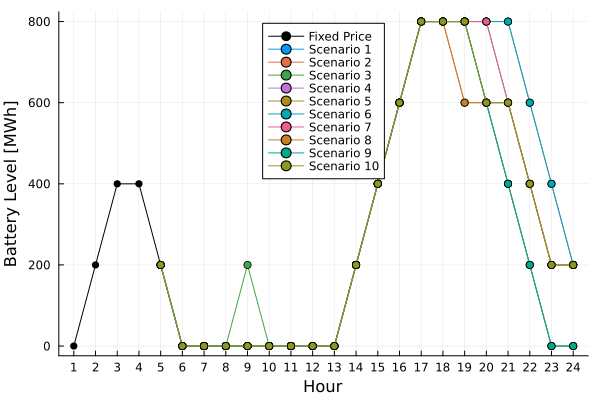

In [11]:
p1 = plot(
    1:F, 
    b1[1:F], 
    label="Fixed Price", 
    xlabel="Hour", 
    ylabel="Battery Level [MWh]", 
    color=:black,
    xticks = 1:24,
    marker= :circle,
    legend = :top,
)

for i in 1:K
    plot!(
        F:24,
        [b1[F];b2_w[i, :]...][1:24-F+1],
        xlabel="Hour",
        ylabel="Battery Level [MWh]",
        label = "Scenario $i",
        color = i,
        marker= :circle,)
end

display(p1)

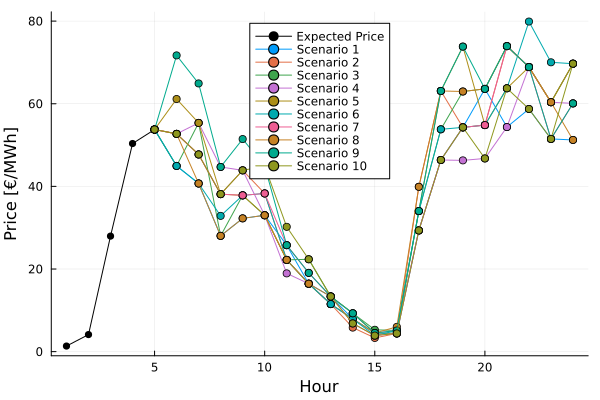

In [12]:
p2 = plot(
    1:F, 
    prices[1:F],
    label= "Expected Price",
    marker= :circle,
    color = :black
)

for i in 1:K
    plot!(
        F:24,
        [prices[F] ;prices_scenarios[i]],
        xlabel="Hour",
        ylabel="Price [€/MWh]",
        label = "Scenario $i",
        color = i,
        marker= :circle,
        legend = :top,)
end

display(p2)